<a href="https://colab.research.google.com/github/panda-sas/nlp-with-transformers/blob/main/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from transformers import pipeline

In [2]:
classifier = pipeline("text-classification")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0


Hugging Face Datasets

In [3]:
!pip install datasets

In [4]:
from datasets import load_dataset

In [5]:
emotions = load_dataset("emotion")

In [6]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [8]:
len(train_ds)

16000

In [9]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [10]:
train_ds.column_names

['text', 'label']

In [11]:
print(train_ds.features)

{'text': Value('string'), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])}


In [12]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [13]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


In [14]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"


In [15]:
emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";",
                               names=["text", "label"])

Datasets to DataFrames

In [16]:
import pandas as pd

In [17]:
emotions.set_format(type="pandas")

In [18]:
df=emotions["train"][:]

In [19]:
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [20]:
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)

In [21]:
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Looking at the Class Distribution

In [22]:
import matplotlib.pyplot as plt

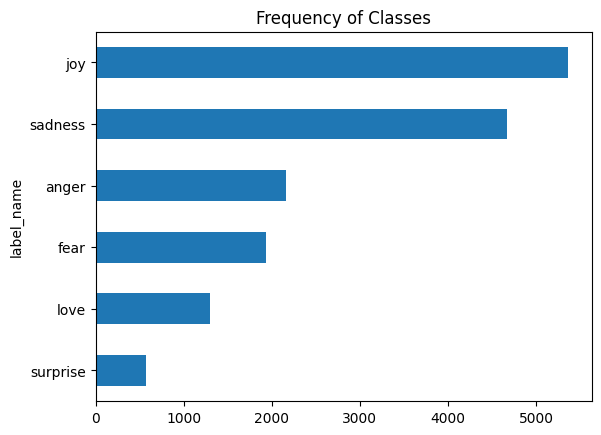

In [23]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

How Long Are Our Tweets?

In [24]:
df["Words per tweet"] = df["text"].str.split().apply(len)

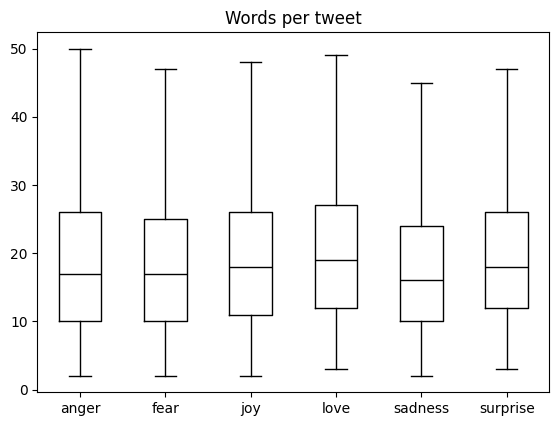

In [25]:
df.boxplot("Words per tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [26]:
emotions.reset_format()

Text to Tokens

In [27]:
text = "Tokenizing text is a core task of NLP."

In [28]:
tokenized_text=list(text)

In [29]:
print(tokenized_text)


['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


Character tokenization

In [30]:
token2idx={ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}

In [31]:
print(token2idx)


{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [32]:
input_ids=[token2idx[token] for token in tokenized_text]

In [33]:
print(input_ids)


[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [34]:
import torch

In [35]:
import torch.nn.functional as F

In [36]:
input_ids=torch.tensor(input_ids)
one_hot_encodings=F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [37]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")

Token: T
Tensor index: 5


In [38]:
print(f"One-hot: {one_hot_encodings[0]}")

One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


Word Tokenization

In [39]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


Subword Tokenization


In [40]:
from transformers import AutoTokenizer

In [41]:
model_ckpt = "distilbert-base-uncased"

In [42]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [43]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [44]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)


['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [45]:
tokenizer.vocab_size

30522

In [46]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [47]:
tokenizer.model_max_length

512

In [48]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

Tokenizing the Whole Dataset

In [49]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [50]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [51]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)


In [52]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


Training a Text Classifier


1. Transformers as Feature Extractors

In [53]:
from transformers import AutoModel

In [54]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)



In [55]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [56]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [57]:
outputs.last_hidden_state.size()


torch.Size([1, 6, 768])

In [58]:
outputs.last_hidden_state[:,0].size()


torch.Size([1, 768])

In [59]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}


In [60]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])


In [61]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)


In [62]:
emotions_hidden["train"].column_names


['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

Creating a feature matrix

In [63]:
import numpy as np


In [64]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

Visualizing the training set


In [65]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.495364,3.974872,0
1,-3.005580,5.032798,0
2,5.305561,7.342205,3
3,-2.178579,6.977469,2
4,-3.409053,6.863053,3


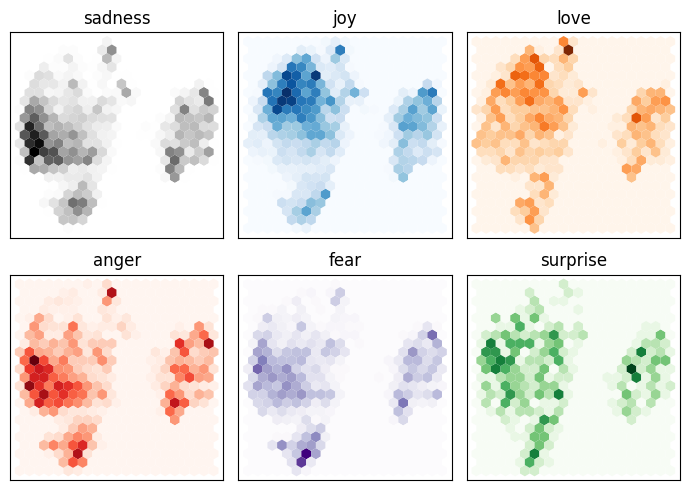

In [66]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()


Training a simple classifier

In [67]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.634

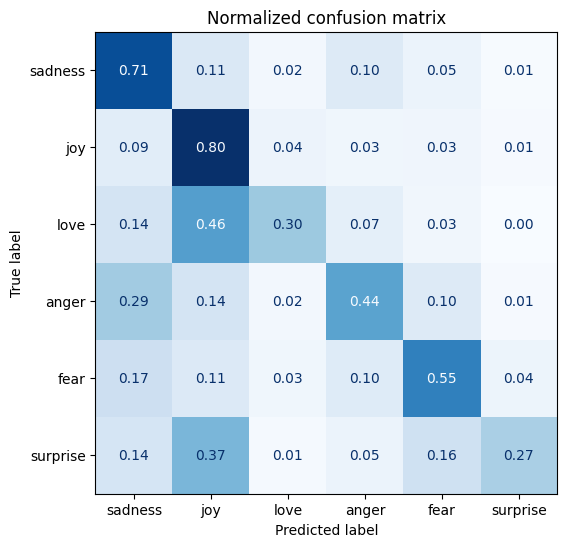

In [68]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

Fine-Tuning Transformers

Loading a pretrained model

In [69]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Defining the performance metrics

In [70]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

Training the model

In [71]:
from huggingface_hub import notebook_login

notebook_login()

In [83]:
from transformers import Trainer, TrainingArguments
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, # Changed to False to prevent upload without login
                                  log_level="error",
                                  report_to="none") # Disable reporting to Weights & Biases

In [84]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

/tmp/ipython-input-4051938262.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Step,Training Loss
250,0.833100
500,0.258000


In [85]:
preds_output = trainer.predict(emotions_encoded["validation"])


In [86]:
preds_output.metrics

{'test_loss': 0.21956020593643188,
 'test_accuracy': 0.9255,
 'test_f1': 0.9252564814279208,
 'test_runtime': 3.9105,
 'test_samples_per_second': 511.447,
 'test_steps_per_second': 8.183}

In [87]:
y_preds = np.argmax(preds_output.predictions, axis=1)


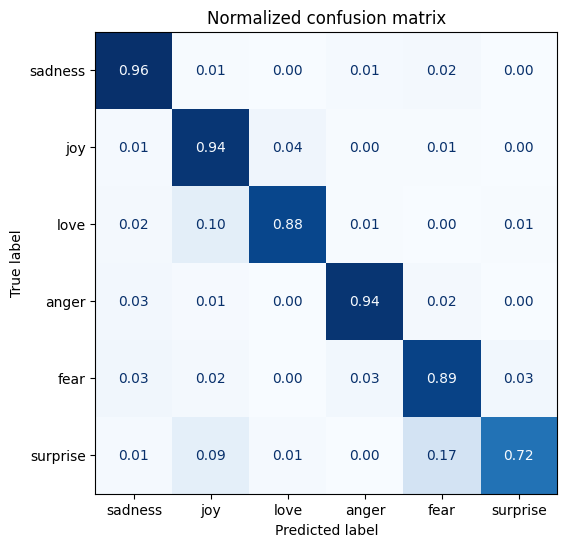

In [88]:
plot_confusion_matrix(y_preds, y_valid, labels)


In [89]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [90]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [91]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [92]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.477153
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.347616
882,i feel badly about reneging on my commitment t...,love,sadness,5.304897
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.122216
177,im sure much of the advantage is psychological...,sadness,joy,5.058749
1950,i as representative of everything thats wrong ...,surprise,sadness,4.988003
1274,i am going to several holiday parties and i ca...,joy,sadness,4.905291
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.752771
465,i would eventually go in to these stores but i...,joy,fear,4.319396
72,i feel that this is important in itself the fa...,joy,sadness,4.192078


In [93]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1873,i feel practically virtuous this month i have ...,joy,joy,0.019691
578,i got to christmas feeling positive about the ...,joy,joy,0.019935
1208,i feel brave again tubing were even going to t...,joy,joy,0.020490
1263,i feel this way about blake lively,joy,joy,0.020549
19,i had lunch with an old friend and it was nice...,joy,joy,0.020636
1320,im feeling positive but its impossible to desc...,joy,joy,0.020691
802,i hate hate hate watching people work and me s...,joy,joy,0.020726
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.020826
1780,ive explained that he is very creative and lov...,joy,joy,0.020905
1513,i have also been getting back into my gym rout...,joy,joy,0.020926


In [94]:
trainer.push_to_hub(commit_message="Training completed!")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...emotion/model.safetensors:   0%|          |  574kB /  268MB            

  ...5762.2fa6428123d2.25009.0:   6%|5         |   302B / 5.21kB            

  ...5797.2fa6428123d2.25009.1:   6%|5         |   302B / 5.21kB            

  ...5823.2fa6428123d2.25009.2:   6%|5         |   303B / 5.22kB            

  ...5865.2fa6428123d2.25009.3:   6%|5         |   303B / 5.22kB            

  ...emotion/training_args.bin:   6%|5         |   339B / 5.84kB            

CommitInfo(commit_url='https://huggingface.co/pandasas/distilbert-base-uncased-finetuned-emotion/commit/1d39588861add3193744c901d227e92298da5f5c', commit_message='Training completed!', commit_description='', oid='1d39588861add3193744c901d227e92298da5f5c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/pandasas/distilbert-base-uncased-finetuned-emotion', endpoint='https://huggingface.co', repo_type='model', repo_id='pandasas/distilbert-base-uncased-finetuned-emotion'), pr_revision=None, pr_num=None)

In [95]:
from transformers import pipeline

# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/872 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [96]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


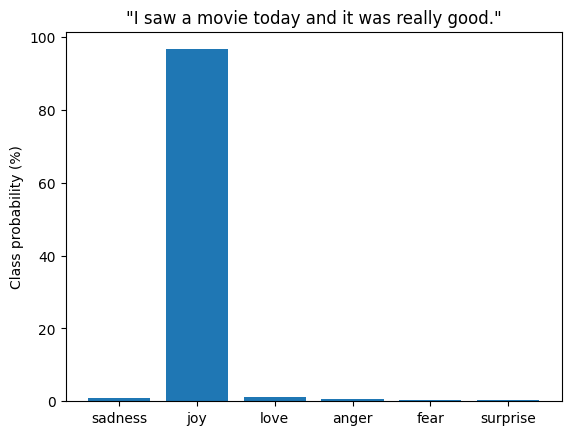

In [97]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()